In [1]:
def findexact(str, substr, index=0):
  offset = str.find(substr)
  ln = len(substr)
  if not index:
    return offset
  return offset + ln + findexact(str[offset+ln :], substr, index-1)

def multifind(str, substrs):
  ret = len(str)
  for substr in substrs:
    index = findexact(str, substr)
    if index > -1 and index < ret:
      ret = index
  if ret == len(str):
    ret = -1
  return ret

In [5]:
!pip install gdown --quiet
!pip install docx2txt --quiet

import gdown
import docx2txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix

In [6]:
!gdown 12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb

txt = docx2txt.process("CCXXXI: la guirlande de Julie.docx")

Downloading...
From: https://drive.google.com/uc?id=12PfGMG4aAXA-dTJ3QmhN0crpqf_4WyZb
To: /content/CCXXXI: la guirlande de Julie.docx
100% 401k/401k [00:00<00:00, 95.1MB/s]


In [7]:
months = ["vendémiaire", "brumaire", "frimaire", "nivôse", "pluviôse", "ventôse",
          "germinal", "floréal", "prairial", "messidor", "thermidor", "fructidor"]
for month in months:
  txt = txt.replace(month.upper(), "")

labels = ["monologue", "story", "fanfic", "chguestk", "cliff", "letter", "lyrics"]

df = pd.DataFrame(columns=["name", "day", "month", "greg_day", "greg_month", "label", "text"])

while(multifind(txt, labels) != -1):
  start = multifind(txt, labels)
  label = txt[start : txt.find(" ", start)]
  txt = txt[start + len(label) :]
  day = pd.Series({
      "name" : txt[findexact(txt, " ", 3) + 1 : findexact(txt, "\n")],
      "day" : int(txt[findexact(txt, " ", 1) + 1 : findexact(txt, " ", 2)]),
      "month" : txt[findexact(txt, " ", 2) + 1 : findexact(txt, ".", 1)],
      "greg_day" : int(txt[findexact(txt, "(") + 1 : findexact(txt, ".")]),
      "greg_month" : int(txt[findexact(txt, ".") + 1 : findexact(txt, ")")]),
      "label" : label,
      "text" : txt[findexact(txt, "\n", 1) + 1 : multifind(txt, labels)],
  })
  df = pd.concat([df, day.to_frame().T], ignore_index=True)

In [8]:
df["sentences"] = df["text"].map(lambda x: len(x.replace("?", ".").replace("!", ".").split(". ")))
df["words"] = df["text"].map(lambda x: len(x.replace("-", "").split()))
df["symbols"] = df["text"].map(lambda x: len(x.replace(" ", "")))
df["capitals"] = df["text"].map(lambda x: len(list(filter(lambda c: c.isupper(), x))))
df["dashes"] = df["text"].map(lambda x: len(list(filter(lambda w: w == "-", x.split()))))
df["questions"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "?", x))))
df["exclamations"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "!", x))))
df["newlines"] = df["text"].map(lambda x: len(list(filter(lambda c: c == "\n", x))))
df["text"] = df["text"].map(lambda x: " ".join(x.split()))

In [9]:
df

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations,newlines
0,raisin,1,vendémiaire,23,9,monologue,люди не изменились. ароматная жидкость мягко к...,15,238,1361,0,4,2,0,22
1,safran,2,vendémiaire,24,9,story,Сафран горд своим прозвищем. нет большого смыс...,22,333,1954,5,3,1,1,14
2,châtaigne,3,vendémiaire,25,9,story,Кристине исполняется четыре года. белокурая ма...,30,514,2838,10,13,5,2,14
3,colchique,4,vendémiaire,26,9,story,с тихим звонком открываются двери лифта. мягки...,35,339,1947,30,12,6,2,40
4,cheval,5,vendémiaire,27,9,story,Келлер Долль привычным движением запрыгивает в...,23,374,2266,10,4,0,0,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,fragon,3,pluviôse,23,1,monologue,нынче в обществе все повально увлечены смешива...,15,270,1623,0,4,1,0,10
123,perce-neige,4,pluviôse,24,1,monologue,"если даже олимпийка Деметра, властная над всем...",12,291,1548,1,4,3,0,10
124,taureau,5,pluviôse,25,1,monologue,"разница между человеческими судьбами - точнее,...",16,306,1800,0,12,0,0,10
125,laurier tin,6,pluviôse,26,1,letter,"вот она, твоя хвалёная зима. чего же в ней хор...",13,256,1424,0,6,2,0,6


In [10]:
df[df["label"] == "fanfic"].sort_values(by=["words"], ascending=False)

,name,day,month,greg_day,greg_month,label,text,sentences,words,symbols,capitals,dashes,questions,exclamations,newlines
18,tournesol,19,vendémiaire,11,10,fanfic,"сам он, по сути, никогда не стремился к соверш...",25,474,2486,6,11,0,0,26
126,amadouvier,7,pluviôse,27,1,fanfic,"раздирает душу смотреть, как тот, кого ты люби...",23,382,1998,2,9,2,2,8
114,chat,25,nivôse,15,1,fanfic,такие женщины - кошки. так же они очаровательн...,15,329,1661,1,7,0,0,10
80,érable sucré,21,frimaire,12,12,fanfic,густая жидкость янтарного оттенка медленно рас...,19,325,1904,4,7,1,0,14
91,houille,2,nivôse,23,12,fanfic,"бред пеленой застилает глаза, превращает прохо...",19,321,1783,2,9,0,0,14
28,orge,29,vendémiaire,21,10,fanfic,она разносит напитки в баре. и от привычке к э...,19,319,1771,4,15,0,1,14
103,grès,14,nivôse,4,1,fanfic,"забудьте всё, что помнили о ней, как забываю э...",23,314,1671,3,6,2,0,14
105,silex,16,nivôse,6,1,fanfic,"ты будто стоишь на краю обрыва, с трепетом заг...",18,303,1564,1,7,0,0,6
60,raiponce,1,frimaire,22,11,fanfic,"жизнь была сказкой. ярко-разноцветной, как кар...",14,279,1652,2,5,0,0,14
63,nèfle,4,frimaire,25,11,fanfic,"вместо холода, твёрдости, разложения, которых ...",16,272,1546,3,6,1,0,14


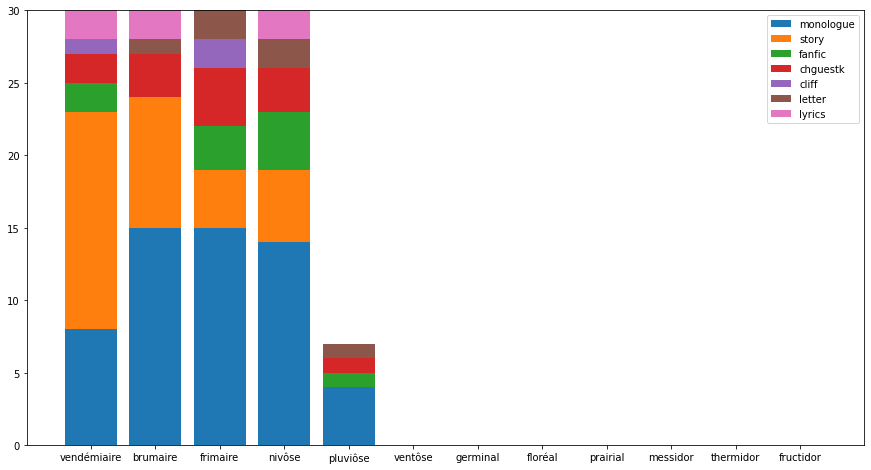

In [11]:
fig = plt.figure(figsize=(15, 8))
bottom = np.zeros(len(months))
for label in labels:
  count = np.empty(0)
  for month in months:
    count = np.append(count, df[(df["month"] == month) & (df["label"] == label)].shape[0])
  plt.bar(np.asarray(months), count, label=label, bottom=bottom)
  bottom += count
plt.legend()
plt.show()

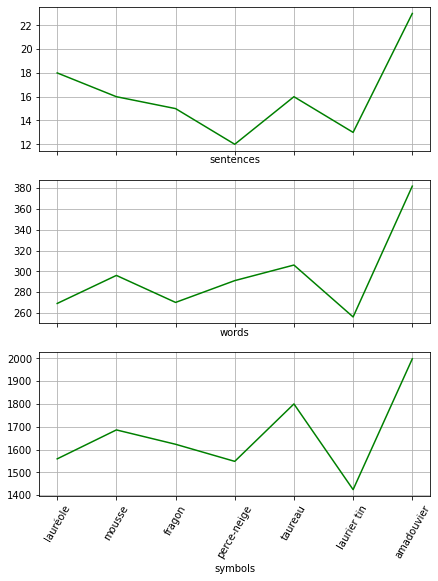

In [12]:
batch = df[df["month"] == months[4]]

plots = ["sentences", "words", "symbols"]
# plots = ["capitals", "dashes", "questions", "exclamations", "newlines"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(batch.shape[0], 3 * len(plots)))
for i in range(len(plots)):
  axs[i].plot(batch["name"], batch[plots[i]], 'g')
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.xticks(rotation=60)
plt.show()

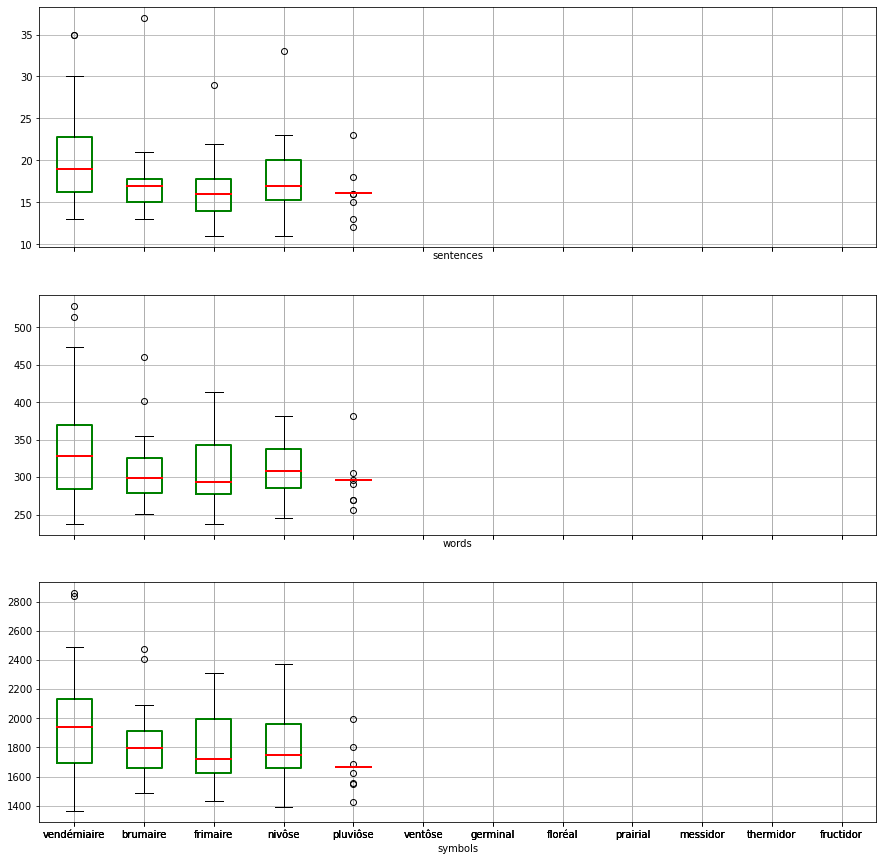

In [13]:
boxprops = dict(linewidth=2, color='g')
medianprops = dict(linewidth=2, color='r')

plots = ["sentences", "words", "symbols"]
fig, axs = plt.subplots(len(plots), 1, sharex=True, figsize=(15, 5 * len(plots)))
for i in range(len(plots)):
  stat = pd.DataFrame(columns=months)
  for month in months:
    stat[month] = df[df["month"] == month][plots[i]].reset_index(drop=True)
    stat[month].fillna(stat[month].mean(), inplace=True)
  axs[i].boxplot(stat.to_numpy(), labels=stat.columns, widths=0.5, boxprops=boxprops, medianprops=medianprops)
  axs[i].set_xlabel(plots[i])
  axs[i].grid()
plt.suptitle("")
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_ridge.py:157: LinAlgWarning: Ill-conditioned matrix (rcond=9.39156e-18): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


linreg MSE:  3.6666666666666665
ridge MSE:  3.2629822369354358


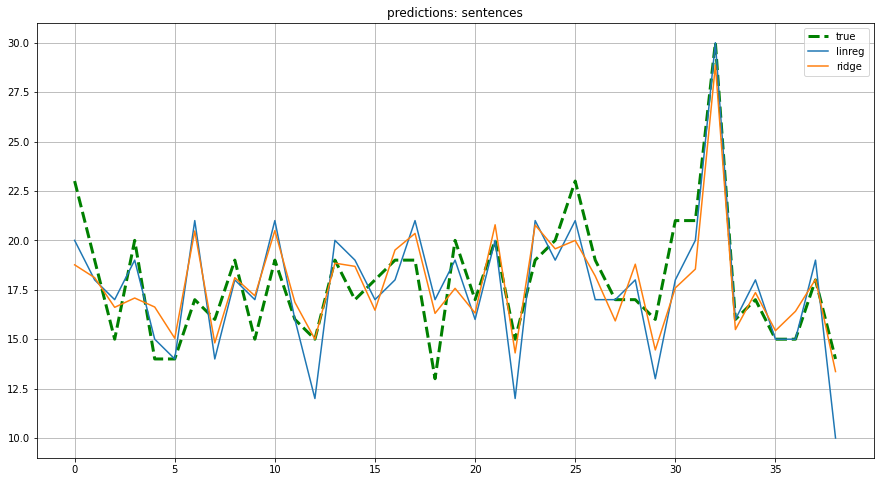

In [14]:
target_column = "sentences"
dum_df = pd.get_dummies(data=df, columns=["month", "label"]).drop(columns=["name", "text"])
X, y = dum_df.drop(columns=[target_column]), dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

params = np.arange(0, 150, 1)
loss = []
for p in params:
  model = Ridge(alpha=p, random_state=88).fit(X_train, y_train)
  y_pred = model.predict(X_test)
  loss.append(mean_squared_error(y_test, y_pred))
alpha = params[np.argmin(loss)]

reg = LinearRegression().fit(X_train, y_train)
y_pred_reg = reg.predict(X_test).astype(int)
ridge = Ridge(alpha=alpha, random_state=88).fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

print("linreg MSE: ", mean_squared_error(y_test, y_pred_reg))
print("ridge MSE: ", mean_squared_error(y_test, y_pred_ridge))

fig = plt.figure(figsize=(15, 8))
plt.plot(range(len(y_test)), y_test, label="true", color='g', linewidth=3, linestyle="dashed")
plt.plot(range(len(y_pred_reg)), y_pred_reg, label="linreg")
plt.plot(range(len(y_pred_ridge)), y_pred_ridge, label="ridge")
plt.title("predictions: " + target_column)
plt.grid()
plt.legend()
plt.show()

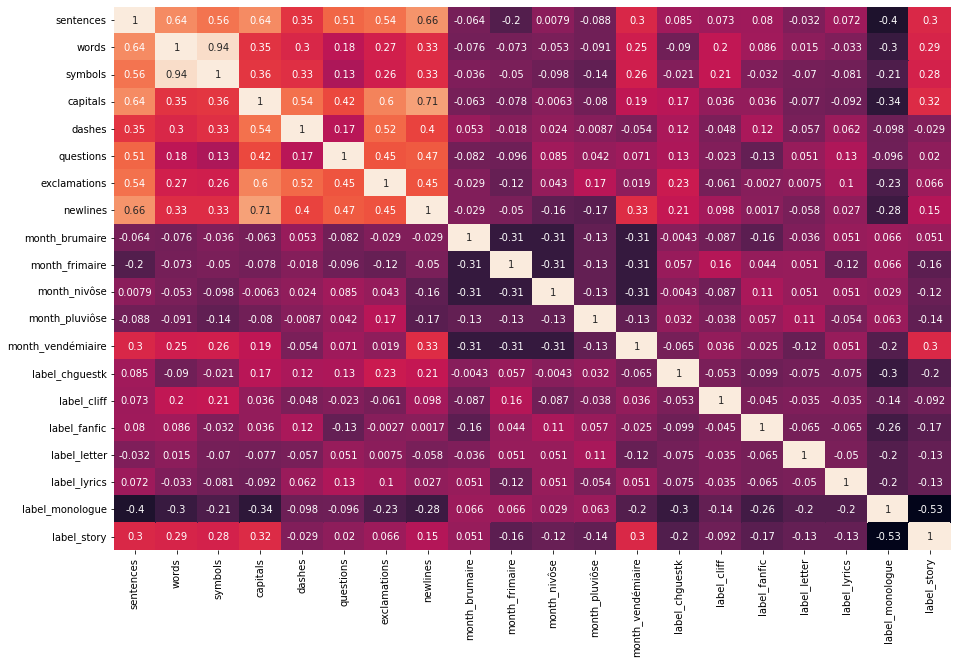

In [15]:
fig = plt.figure(figsize=(15, 10))
sns.heatmap(dum_df.corr(), annot=True, cbar=False)

In [ ]:
ops = list(map(lambda x: x[:findexact(x, " ", 0)], df["text"]))
ops.sort(key=lambda x: x.lower())

In [ ]:
# todo: something that has to do with text processing ?

accuracy:  0.5128205128205128


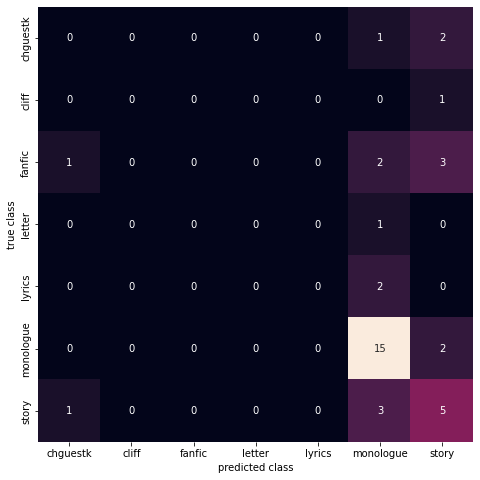

In [16]:
target_column = "label"
clf_dum_df = pd.get_dummies(data=df, columns=["month"]).drop(columns=["name", "text"])
X, y = clf_dum_df.drop(columns=[target_column]), clf_dum_df[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=88)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

clf = RandomForestClassifier(random_state=88).fit(X_train, y_train)
y_pred_clf = clf.predict(X_test)

print("accuracy: ", classification_report(y_test, y_pred_clf, labels=clf.classes_, zero_division=0, output_dict=True)["accuracy"])

fig = plt.figure(figsize=(8, 8))
sns.heatmap(confusion_matrix(y_test, y_pred_clf, labels=clf.classes_),
            xticklabels=clf.classes_, yticklabels=clf.classes_, annot=True, cbar=False, square=True)
plt.xlabel("predicted class")
plt.ylabel("true class")
plt.show()